In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

import pickle
from zipfile import ZipFile, ZIP_DEFLATED
import os

In [2]:
# Read the data
df_original = pd.read_csv(r"datasets/churn.csv")
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# For this data, we assume the best metric to consider is the F1 Score

# Chech the class balance
df_original["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [4]:
# Calculate the average balance of customers who churned
avg_churned_balance = df_original[df_original["Exited"] == 1]["Balance"].mean()
avg_churned_balance

91108.53933726068

In [5]:
# Prepare the data
# Drop the RowNumber, CustomerID, Surname, and Gender columns
# In this example, we don't want the model to make decisions based on gender
df = df_original.drop(columns=["RowNumber", "CustomerId", "Surname", "Gender"])
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Encode the categorical variables, Geography only in this case
# Use drop_first = True to use less columns, 2 instead of 3 here
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


In [7]:
# Split the data
y = df["Exited"]
x = df.copy().drop(columns=["Exited"])

# Use stratify to maintain the same distribution of the labels of the original data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, stratify=y, random_state=42
)

In [8]:
# Perform the hyperparameter optimization with a validation set
cv_params = {
    "max_depth": [4, 5, 6, 7, 8],
    "min_child_weight": [1, 2, 3, 4, 5],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [75, 100, 125, 150],
}
scoring = ["accuracy", "precision", "recall", "f1"]

xgb = XGBClassifier(objective="binary:logistic", random_state=0)

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit="f1", verbose=1)

In [9]:
# %%time
# xgb_cv.fit(x_train, y_train)

In [10]:
# This optimization process took less time than the cross validation
# Because the cross validation has to perform 5 validation in each model
# Whereas with this approach, the validation only occurs once per model

In [11]:
# The optimization took a lot of time, let's save the result to avoid training again
path_pickle = r"./models/xgb_cv_grid_search.pickle"
path_zip = r"./models/xgb_cv_grid_search.zip"

In [12]:
# # Save the model to a file

# # Save the CV grid search
# with open(path_pickle, "wb") as f:
#     pickle.dump(xgb_cv, f)

# # Compress the file to save space
# with ZipFile(path_zip, "w") as myzip:
#     myzip.write(path_pickle, compress_type=ZIP_DEFLATED, compresslevel=9)
#     # Delete the uncompressed file
#     os.remove(path_pickle)

In [13]:
# Load the model from a file

# Extract the file from the zip
with ZipFile(path_zip, "r") as myzip:
    myzip.extractall()

# Load the model from the picle file
with open(path_pickle, "rb") as f:
    xgb_cv = pickle.load(f)

# Delete the uncompressed file
os.remove(path_pickle)

In [14]:
xgb_cv

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [15]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100}

In [16]:
xgb_cv.best_score_

0.5811316484816358

In [17]:
xgb_cv.best_index_

5

In [18]:
pd.DataFrame(xgb_cv.cv_results_).loc[xgb_cv.best_index_]

mean_fit_time                                                      0.060606
std_fit_time                                                        0.00242
mean_score_time                                                    0.009995
std_score_time                                                     0.000005
param_learning_rate                                                     0.1
param_max_depth                                                           4
param_min_child_weight                                                    2
param_n_estimators                                                      100
params                    {'learning_rate': 0.1, 'max_depth': 4, 'min_ch...
split0_test_accuracy                                                  0.864
split1_test_accuracy                                                  0.858
split2_test_accuracy                                               0.865333
split3_test_accuracy                                                   0.86
split4_test_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

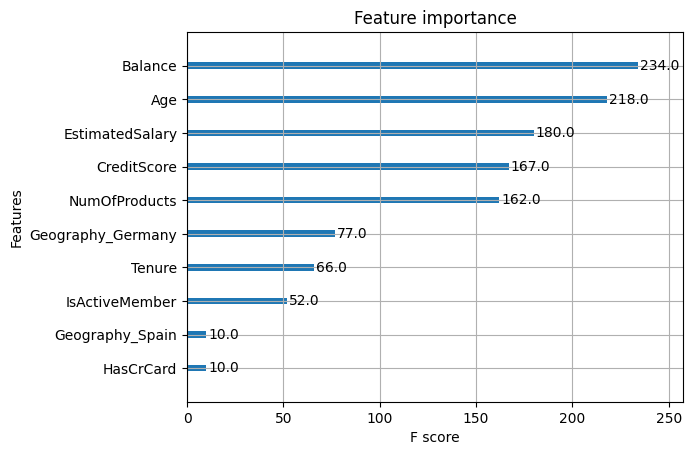

In [19]:
plot_importance(xgb_cv.best_estimator_)

In [20]:
# Make the predictions
y_pred = xgb_cv.best_estimator_.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [21]:
# Performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.873
Precision: 0.803
Recall: 0.497
F1 Score: 0.614


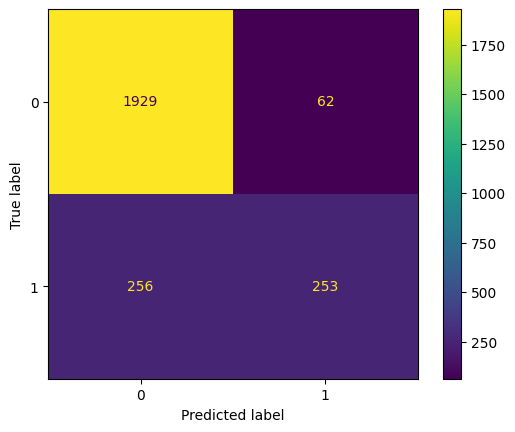

In [22]:
# Inspect the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_cv.best_estimator_.classes_)
disp_cm = ConfusionMatrixDisplay(cm, display_labels=xgb_cv.best_estimator_.classes_)
disp_cm.plot()
plt.show()